# Amazon find food reviews:

Data consists of 500,000 reviews from amazon fine food starting October 1999 to October 2012

# Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
from ipywidgets import widgets, interactive
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import copy
from textblob import TextBlob


# Reading the data

In [2]:
df = pd.read_csv("Reviews.csv")

In [51]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [52]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# Basic statistics on product, users and reviews

In [53]:
print('Number of unique products:', len(df['ProductId'].unique()))

Number of unique products: 74258


In [54]:
print('Number of unique users:', len(df['UserId'].unique()))

Number of unique users: 256059


In [55]:
print('Estimate of number unique reviews:', len(df['Text'].unique()))

Estimate of number unique reviews: 393579


In [56]:
print('Initial size')
df.shape

Initial size


(568454, 10)

# Data pre-processing

# Converting the Unix time to actual time

In [3]:
df['Date'] = pd.to_datetime(df['Time'], unit='s')

In [4]:
# calculate Count of reviews for each product
df_counts = df[['ProductId', 'Id']]
df_counts = df_counts.groupby(['ProductId']).count().reset_index().rename(columns = {'Id':'Counts'})

# calculate Min and Max review date for each product
df_minmax = df.groupby(['ProductId']).agg({'Date':[np.min,np.max]}).reset_index().rename(columns = {'amin':'Min', 'amax':'Max'})
df_minmax.columns = ["".join(x) for x in df_minmax.columns.ravel()]

# merge two dataframes
df_agg = pd.merge(df_counts, df_minmax, on=["ProductId"])
df_agg.head()

,ProductId,Counts,DateMin,DateMax
0,0006641040,37,1999-10-08,2012-09-23
1,141278509X,1,2012-03-24,2012-03-24
2,2734888454,2,2007-10-11,2007-11-25
3,2841233731,1,2012-08-25,2012-08-25
4,7310172001,173,2005-01-04,2012-10-26


In [5]:
# calculate the difference in years and sort in descending order by years and then counts
df_agg['Diff_Years'] = df_agg['DateMax'] - df_agg['DateMin']
df_agg['Diff_Years'] = (df_agg['Diff_Years']/np.timedelta64(1, 'Y')).astype(int)
df_sorted = df_agg.sort_values(['Diff_Years', 'Counts'], ascending = (False,False))
df_sorted.head()

,ProductId,Counts,DateMin,DateMax,Diff_Years
12,B00004CXX9,195,1999-12-02,2012-10-22,12
11,B00004CI84,189,1999-12-06,2012-10-22,12
20,B00004RYGX,189,1999-12-06,2012-10-22,12
22,B00004S1C6,61,2000-08-09,2012-10-19,12
8,B00002N8SM,38,2000-01-24,2012-09-28,12


In [6]:
# Filter the rows by year 2006 and Diff_Years = 6. Also, select only top 15 product id's.
df_sorted = df_sorted[(df_sorted['Diff_Years'] == 6) & (df_sorted['DateMin'] > '2005-12-31') & (df_sorted['DateMax'] < '2013-01-01')]
df_sorted = df_sorted[['ProductId']].head(15)
df_sorted

,ProductId
7387,B000CNB4LE
46406,B003CIBPN8
60392,B004SRFYMK
60393,B004SRH2B6
5473,B0007A0AQM
5474,B0007A0AQW
7062,B000BRR8VQ
11712,B000H0ZJHW
11713,B000H0ZJIG
11728,B000H1217M


In [7]:
# the final dataframe with all columns of the selected 15 products
df_final = pd.merge(df, df_sorted, on = ['ProductId'])
len(df_final)

5986

In [62]:
df_final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Date
0,29992,B000DZFMEQ,A3P70L7MF8L3L3,J. E. Pote,1,1,5,1268179200,Pamela's Bread Mix,At last a really delicious bread mix that tast...,2010-03-10
1,29993,B000DZFMEQ,A1ASH1LE6HZ3Y3,Linda M. Walker,1,1,2,1256947200,Dated,I purchased a case of this bread mix because m...,2009-10-31


# Cleaning the text of reviews (multiple steps)

* Removing partially scraped containing html headers
* Remove special characters e.g. "{$1?&") from the text
* Removing extra space, parsing the data
* Removing NaN (very few)

# Removing partially scraped html from data

In [8]:
#function to remove hmtl tags and special char from text review.

special_char_list=['</span','<br/>','<br>','br','href','</a>''\\','`','\"',"'",'*','_','{','}','[',']','(',')',';','@','^','&','>','#','+',':','-','_','=','|','>','<','~','.','!','$','/',',','?','%','0','1','2','3','4','5','6','7','8','9']

def clean_text(col):      
    for word in special_char_list:
        if word in col: 
            col=col.replace(word,"").replace("  "," ")
    return col

In [9]:
# applying special character removal to dataframe
df_final['Text']=df_final['Text'].apply(clean_text)

In [10]:
df_final.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
Date                      0
dtype: int64

# Exploratory data analysis

# Trend  in Review count over years

In [21]:
#creating "Year" attribute in data frame
df_final['Year'] = df_final.Date.dt.year

df_review = df_final[['Year','Text']]
df_review = df_review.groupby(['Year']).count().reset_index().rename(columns = {'Text':'Counts'})

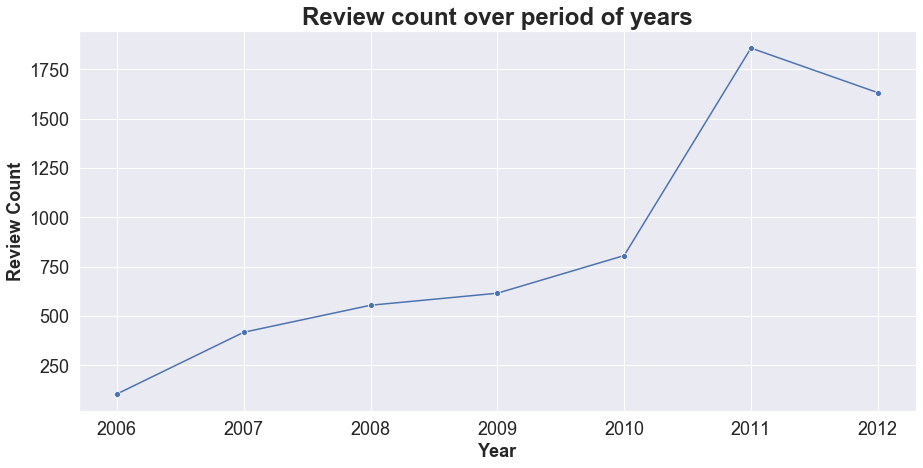

In [67]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

title = 'Review count over period of years'
f,ax = plt.subplots(1, figsize=(15,7))
ax = sns.lineplot(x="Year", y="Counts", marker='o',data=df_review, ci=90)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.set_xlabel('Year', fontsize=18, weight = 'bold')
ax.set_ylabel('Review Count', fontsize=18, weight = 'bold')
plt.title(title, fontsize=24, y=1, weight = 'bold')
plt.show()

# Distribution of count of reviews across products

In [68]:
df_review_products = df_final.groupby(['ProductId']).count()['Id'].reset_index().sort_values(by='Id',ascending=False)
# df_review_products.head()

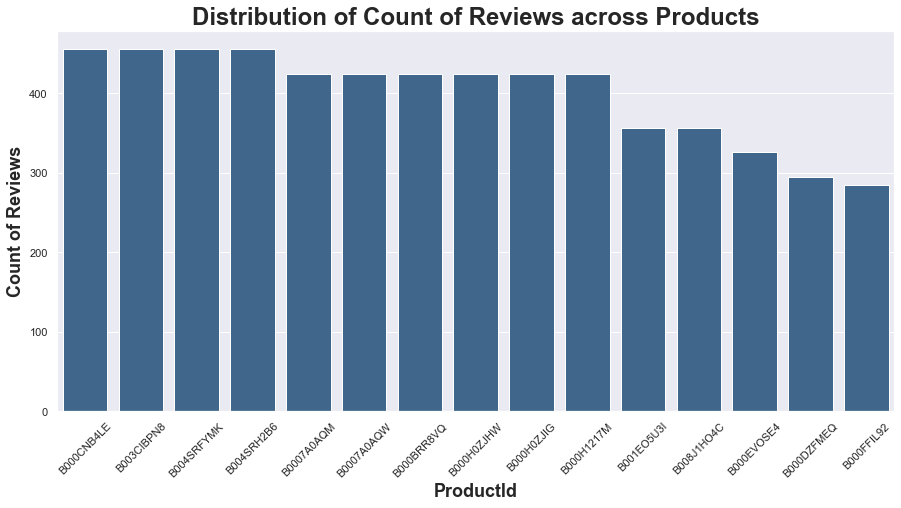

In [69]:
plt.figure(figsize=(15, 7))
bar_plot = sns.barplot(x="ProductId", y="Id", data=df_review_products, color=(0.2, 0.4, 0.6, 0.6))
#plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.title('Distribution of Count of Reviews across Products',fontsize=24, y=1, weight = 'bold')
plt.ylabel('Count of Reviews',fontsize=18, weight = 'bold')
plt.xlabel('ProductId',fontsize=18, weight = 'bold')
plt.show();

# Distribution of Avg. score of Reviews across Products

In [70]:
df_avg_review_products = df_final.groupby(['ProductId']).mean()['Score'].reset_index().sort_values(by='Score',ascending=False)
# df_avg_review_products.head()

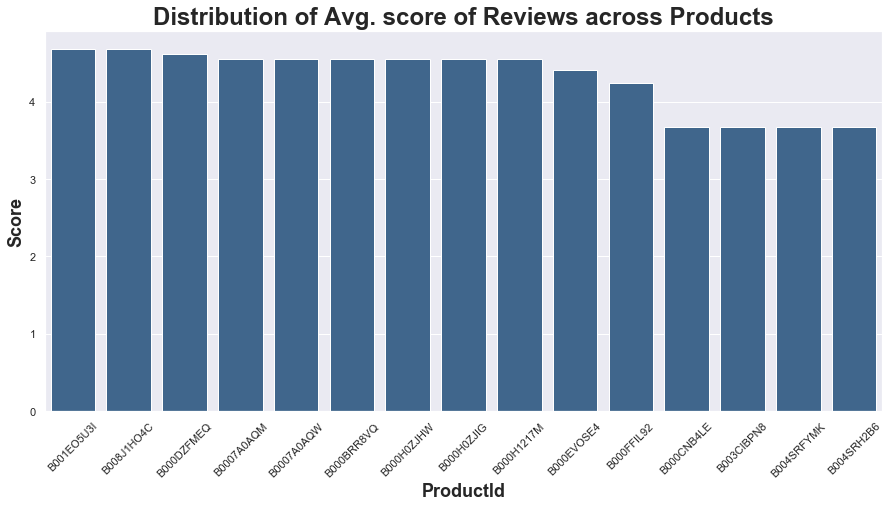

In [71]:
plt.figure(figsize=(15, 7))
bar_plot = sns.barplot(x="ProductId", y="Score", data=df_avg_review_products, color=(0.2, 0.4, 0.6, 0.6))
#plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.title('Distribution of Avg. score of Reviews across Products',fontsize=24, y=1, weight = 'bold')
plt.ylabel('Score',fontsize=18, weight = 'bold')
plt.xlabel('ProductId',fontsize=18, weight = 'bold')
plt.show();

# Total Number of Reviews of Products over the period of Time

In [72]:
#creating pivoted data for heatmap chart
reviews_product_years = pd.crosstab(df_final['ProductId'],df_final['Year'])
reviews_product_years.head()

Year,2006,2007,2008,2009,2010,2011,2012
ProductId,,,,,,,
B0007A0AQM,1,9,25,48,35,139,167
B0007A0AQW,1,9,25,48,35,139,167
B000BRR8VQ,1,9,25,48,35,139,167
B000CNB4LE,6,9,10,11,100,198,122
B000DZFMEQ,9,44,59,72,56,38,17


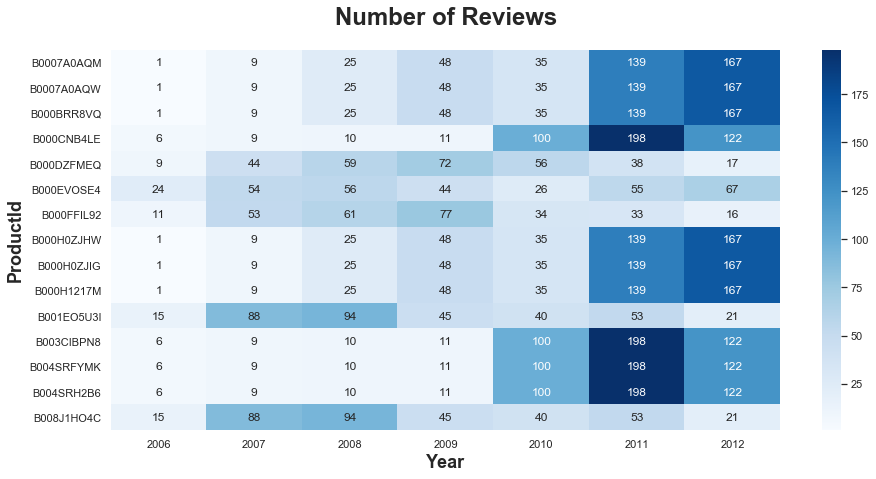

In [73]:
#creating heatmap plot
fig, ax = plt.subplots(figsize = (15,7))
plt.title("Number of Reviews",fontsize=24, y=1, weight = 'bold')
plt.ylabel('ProductId',fontsize=18, weight = 'bold')
plt.xlabel('Year',fontsize=18, weight = 'bold')
ttl = ax.title
ttl.set_position([0.5,1.05])

sns.heatmap(reviews_product_years,annot=True,cmap='Blues', fmt='g');

# Average Score of Products over the period of Time

In [74]:
#creating pivoted data for heatmap chart
score_product_years = pd.pivot_table(df_final, values='Score', index=['ProductId'],columns=['Year'], aggfunc=np.mean)
score_product_years

Year,2006,2007,2008,2009,2010,2011,2012
ProductId,,,,,,,
B0007A0AQM,5.000000,5.000000,4.920000,4.645833,4.342857,4.474820,4.532934
B0007A0AQW,5.000000,5.000000,4.920000,4.645833,4.342857,4.474820,4.532934
B000BRR8VQ,5.000000,5.000000,4.920000,4.645833,4.342857,4.474820,4.532934
B000CNB4LE,4.166667,4.888889,4.200000,4.818182,2.790000,3.762626,3.983607
B000DZFMEQ,5.000000,4.636364,4.728814,4.625000,4.375000,4.631579,4.588235
B000EVOSE4,4.750000,4.388889,4.303571,4.340909,4.576923,4.272727,4.507463
B000FFIL92,4.454545,4.245283,4.213115,4.350649,3.647059,4.545455,4.312500
B000H0ZJHW,5.000000,5.000000,4.920000,4.645833,4.342857,4.474820,4.532934
B000H0ZJIG,5.000000,5.000000,4.920000,4.645833,4.342857,4.474820,4.532934


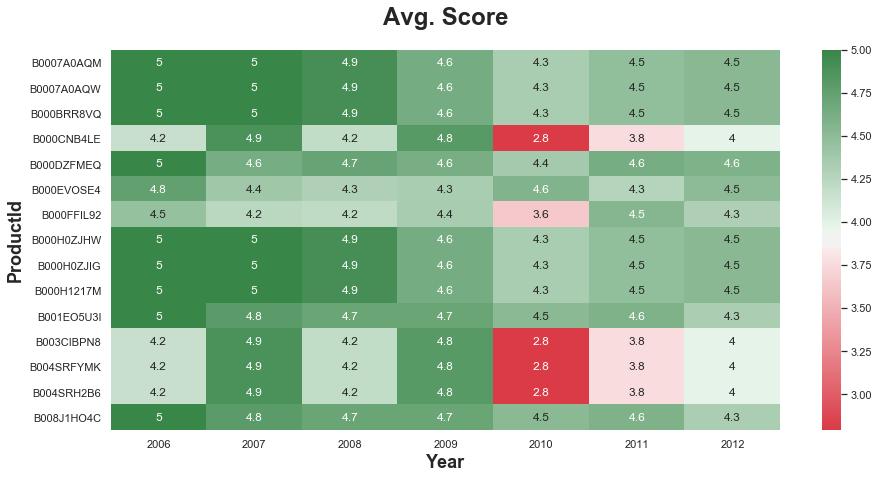

In [75]:
#creating heatmap plot
fig, ax = plt.subplots(figsize = (15,7))
plt.title("Avg. Score",fontsize=24, y=1, weight = 'bold')
plt.ylabel('ProductId',fontsize=18, weight = 'bold')
plt.xlabel('Year',fontsize=18, weight = 'bold')
ttl = ax.title
ttl.set_position([0.5,1.05])

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 133, as_cmap=True)
sns.heatmap(score_product_years,annot=True,cmap=cmap, fmt='.2g');

In [11]:
#removing products with similar trend
ProdcutIds = ['B0007A0AQW','B000BRR8VQ','B000H0ZJIG','B000H1217M','B004SRH2B6']
df_final = df_final[df_final.ProductId.isin(ProdcutIds)==False]

# Sentiment Analysis

# Changing Score Attribute to Sentiment Text

In [12]:
df_final.loc[df_final.Score>3,'Score_Sentiment'] = 'Positive'
df_final.loc[df_final.Score==3,'Score_Sentiment'] = 'Neutral'
df_final.loc[df_final.Score<3,'Score_Sentiment'] = 'Negative'
df_final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Date,Score_Sentiment
0,29992,B000DZFMEQ,A3P70L7MF8L3L3,J. E. Pote,1,1,5,1268179200,Pamela's Bread Mix,At last a really delicious ead mix that tastes...,2010-03-10,Positive
1,29993,B000DZFMEQ,A1ASH1LE6HZ3Y3,Linda M. Walker,1,1,2,1256947200,Dated,I purchased a case of this ead mix because my ...,2009-10-31,Negative
2,29994,B000DZFMEQ,A32PVZEV0QTHMK,Manisha,1,1,3,1256515200,TOO SWEET,I thought this product would be more like eadb...,2009-10-26,Neutral
3,29995,B000DZFMEQ,A1RRCP78CDDIOS,"Beth Wisser ""Beth""",1,1,3,1254268800,Not the best,I really like Pamelas baking mix so I tried th...,2009-09-30,Neutral
4,29996,B000DZFMEQ,AU714FVNMGW4E,"Anita L. Burnham ""Anita B""",1,1,5,1253750400,Gluten Free Goodness,This is the best gf ead mix I have found by fa...,2009-09-24,Positive


# Product & Reviews (Positive, Neutral and Negative) Distribution

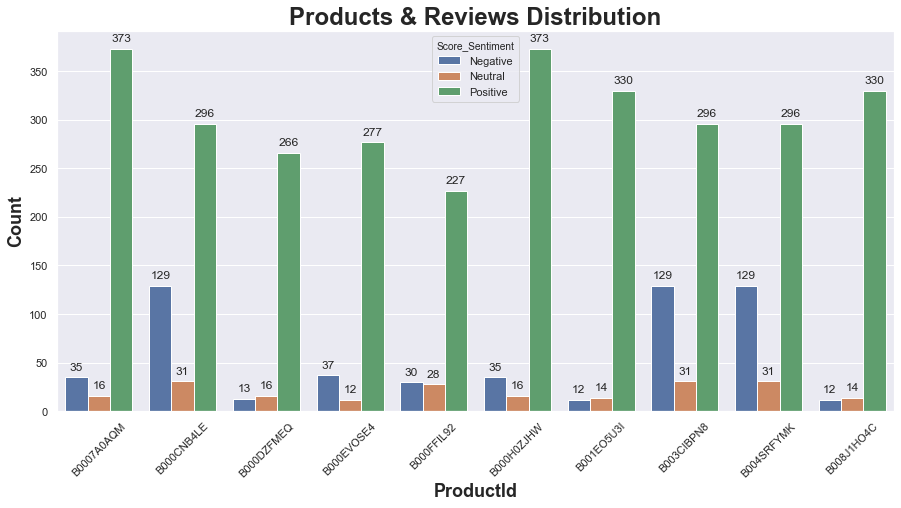

In [78]:
product_review_groupby = df_final.groupby(['ProductId','Score_Sentiment']).count()['Id'].reset_index()

plt.figure(figsize=(15, 7))
bar_plot = sns.barplot(x="ProductId", y="Id", hue="Score_Sentiment", data=product_review_groupby)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.xticks(rotation=45)
plt.title('Products & Reviews Distribution',fontsize=24, y=1, weight = 'bold')
for p in bar_plot.patches:
    bar_plot.annotate(str(format(p.get_height(), '.0f')), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylabel('Count',fontsize=18, weight = 'bold')
plt.xlabel('ProductId',fontsize=18, weight = 'bold')
plt.show();

In [79]:
product_review_year_groupby = df_final.groupby(['ProductId','Score_Sentiment','Year']).count()['Id'].reset_index()
product_pos_review_groupby = product_review_year_groupby[product_review_year_groupby['Score_Sentiment']=='Positive']
product_neg_review_groupby = product_review_year_groupby[product_review_year_groupby['Score_Sentiment']=='Negative']
product_neu_review_groupby = product_review_year_groupby[product_review_year_groupby['Score_Sentiment']=='Neutral']

# Product & Reviews (Positive) Distribution across Years

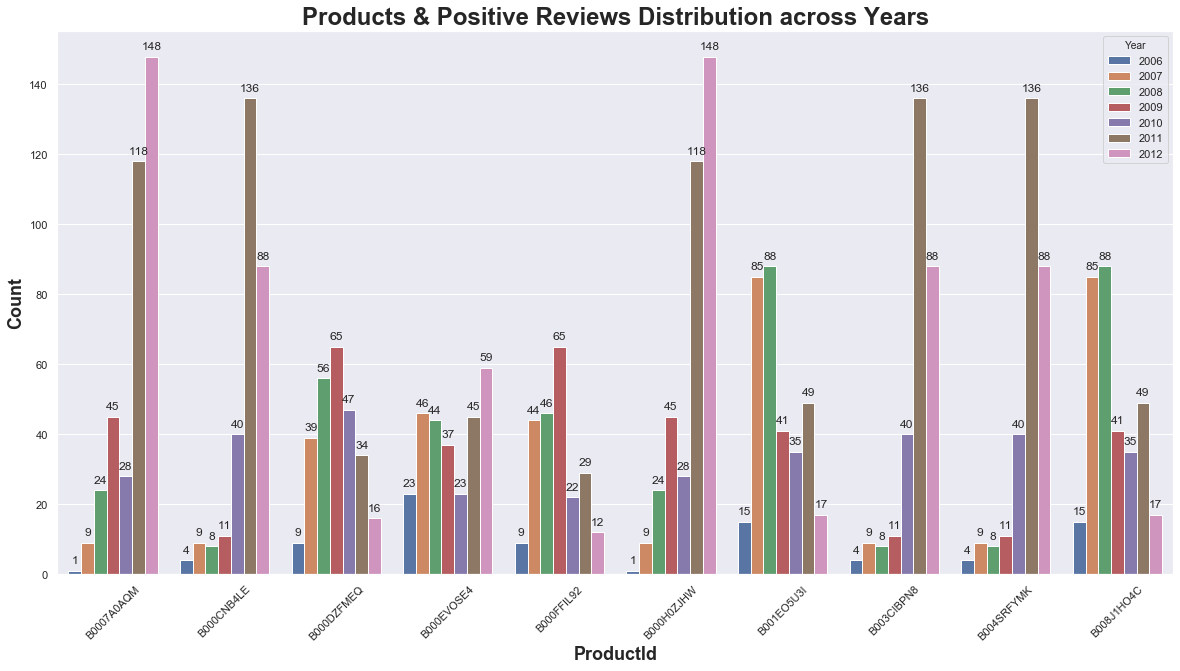

In [80]:
plt.figure(figsize=(20, 10))
bar_plot = sns.barplot(x="ProductId", y="Id", hue="Year", data=product_pos_review_groupby)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.xticks(rotation=45)
plt.title('Products & Positive Reviews Distribution across Years',fontsize=24, y=1, weight = 'bold')
for p in bar_plot.patches:
    bar_plot.annotate(str(format(p.get_height(), '.0f')), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylabel('Count',fontsize=18, weight = 'bold')
plt.xlabel('ProductId',fontsize=18, weight = 'bold')
plt.show();

In [81]:
productid_dropdown = widgets.Dropdown(
    options = ['All'] + list(product_review_year_groupby['ProductId'].unique()),
    value = 'All',
    description = 'Product ID'
)

In [82]:
product_review_year_groupby.head()
product_review_year_groupby.groupby(['Score_Sentiment','Year']).sum()['Id'].reset_index()

,Score_Sentiment,Year,Id
0,Negative,2006,2
1,Negative,2007,15
2,Negative,2008,24
3,Negative,2009,23
4,Negative,2010,177
5,Negative,2011,206
6,Negative,2012,114
7,Neutral,2006,7
8,Neutral,2007,13
9,Neutral,2008,26


In [83]:
def line_chart_per_product(productid_dropdown):
    
    if productid_dropdown == 'All':
        review_year_groupby_prod = product_review_year_groupby.groupby(['Score_Sentiment','Year']).sum()['Id'].reset_index()
    else:
        review_year_groupby_prod = product_review_year_groupby[product_review_year_groupby['ProductId']==productid_dropdown]
    
    plt.figure(figsize=(15, 7))
    line_plot = sns.lineplot(x="Year", y="Id", hue="Score_Sentiment", data=review_year_groupby_prod)
    plt.ticklabel_format(style='plain', axis='y',useOffset=False)
    plt.xticks(rotation=45)
    plt.title('Distribution of Reviews across Years',fontsize=22, y=1, weight = 'bold')
    for p in bar_plot.patches:
        bar_plot.annotate(str(format(p.get_height(), '.0f')), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    plt.ylabel('Count',fontsize=18, weight = 'bold')
    plt.xlabel('Year',fontsize=18, weight = 'bold')
    plt.show();    

In [84]:
interactive(line_chart_per_product,productid_dropdown=productid_dropdown)

interactive(children=(Dropdown(description='Product ID', options=('All', 'B0007A0AQM', 'B000CNB4LE', 'B000DZFM…

# Vader Sentiment Analysis

In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [14]:
for i in df_final.index:
    sentimentdict = analyzer.polarity_scores(df_final.loc[i,'Text'])
    df_final.loc[i,'Vader_Pos_Score'] = sentimentdict['pos']
    df_final.loc[i,'Vader_Neg_Score'] = sentimentdict['neg']
    df_final.loc[i,'Vader_Neu_Score'] = sentimentdict['neu']
    df_final.loc[i,'Vader_Compound_Score'] = sentimentdict['compound']
    
    if sentimentdict['compound'] >0.3:
        df_final.loc[i,'Final_Vader_Sentiment_Type2'] = 'Positive'
    elif sentimentdict['compound'] <-0.3:
        df_final.loc[i,'Final_Vader_Sentiment_Type2'] = 'Negative'
    else:
        df_final.loc[i,'Final_Vader_Sentiment_Type2'] = 'Neutral'
    
    sentimentdict.pop('compound')
    max_value = max(sentimentdict.values())
    for key,val in sentimentdict.items():
        if val == max_value: 
            df_final.loc[i,'Final_Vader_Sentiment_Type'] = key

df_final.head(100)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Date,Score_Sentiment,Vader_Pos_Score,Vader_Neg_Score,Vader_Neu_Score,Vader_Compound_Score,Final_Vader_Sentiment_Type2,Final_Vader_Sentiment_Type
0,29992,B000DZFMEQ,A3P70L7MF8L3L3,J. E. Pote,1,1,5,1268179200,Pamela's Bread Mix,At last a really delicious ead mix that tastes...,2010-03-10,Positive,0.286,0.022,0.692,0.9930,Positive,neu
1,29993,B000DZFMEQ,A1ASH1LE6HZ3Y3,Linda M. Walker,1,1,2,1256947200,Dated,I purchased a case of this ead mix because my ...,2009-10-31,Negative,0.068,0.041,0.891,0.7111,Positive,neu
2,29994,B000DZFMEQ,A32PVZEV0QTHMK,Manisha,1,1,3,1256515200,TOO SWEET,I thought this product would be more like eadb...,2009-10-26,Neutral,0.170,0.055,0.775,0.7900,Positive,neu
3,29995,B000DZFMEQ,A1RRCP78CDDIOS,"Beth Wisser ""Beth""",1,1,3,1254268800,Not the best,I really like Pamelas baking mix so I tried th...,2009-09-30,Neutral,0.111,0.082,0.806,0.4254,Positive,neu
4,29996,B000DZFMEQ,AU714FVNMGW4E,"Anita L. Burnham ""Anita B""",1,1,5,1253750400,Gluten Free Goodness,This is the best gf ead mix I have found by fa...,2009-09-24,Positive,0.320,0.000,0.680,0.9722,Positive,neu
5,29997,B000DZFMEQ,A3CZKBRQYTW7W0,Denise Estep,1,1,5,1252713600,GLUTEN FREE BREAD,THIS BREAD MIX IS THE CLOSEST THING TO REGULAR...,2009-09-12,Positive,0.132,0.000,0.868,0.4404,Positive,neu
6,29998,B000DZFMEQ,A2LQTTTXBLFFAO,"lovereading ""Gin""",1,1,5,1250208000,Pamela's bread mix,Delicious and easy to make An excellent ead mi...,2009-08-14,Positive,0.402,0.000,0.598,0.9300,Positive,neu
7,29999,B000DZFMEQ,A2A0UL2OFEIPH4,"Jo ""Jo""",1,1,5,1248048000,Great bread!,I bought this mix for my daughters boyfriend s...,2009-07-20,Positive,0.209,0.036,0.755,0.9307,Positive,neu
8,30000,B000DZFMEQ,A32HT263MGTCQD,Keith Roys,1,1,5,1247184000,Great price on a great gluten-free product!,We have paid over a package in health food sto...,2009-07-10,Positive,0.272,0.000,0.728,0.9607,Positive,neu
9,30001,B000DZFMEQ,A3QAHX0VWAYXCU,T Jones,1,1,5,1208649600,Awesome! Strongly recommend.,Ive taken the glutenfree baking classes from t...,2008-04-20,Positive,0.167,0.036,0.797,0.9476,Positive,neu


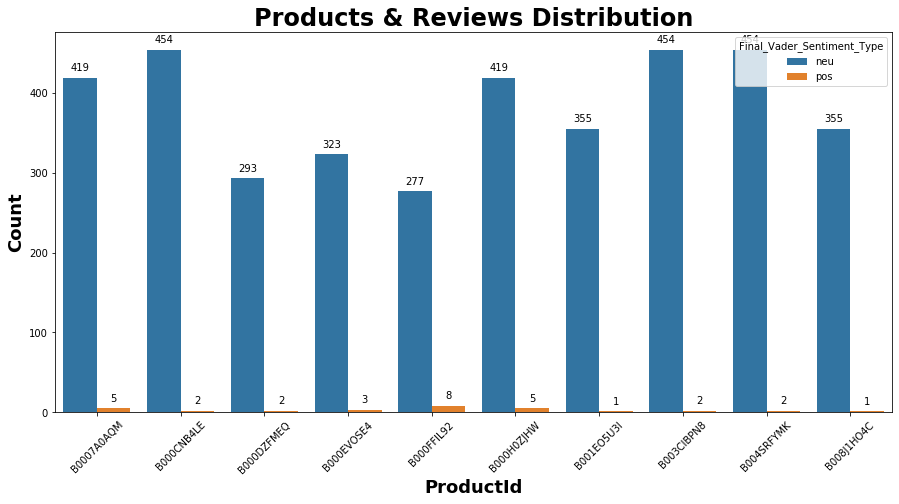

In [15]:
product_review_groupby_vader = df_final.groupby(['ProductId','Final_Vader_Sentiment_Type']).count()['Id'].reset_index()

plt.figure(figsize=(15, 7))
bar_plot = sns.barplot(x="ProductId", y="Id", hue="Final_Vader_Sentiment_Type", data=product_review_groupby_vader)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.xticks(rotation=45)
plt.title('Products & Reviews Distribution',fontsize=24, y=1, weight = 'bold')
for p in bar_plot.patches:
    bar_plot.annotate(str(format(p.get_height(), '.0f')), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylabel('Count',fontsize=18, weight = 'bold')
plt.xlabel('ProductId',fontsize=18, weight = 'bold')
plt.show();


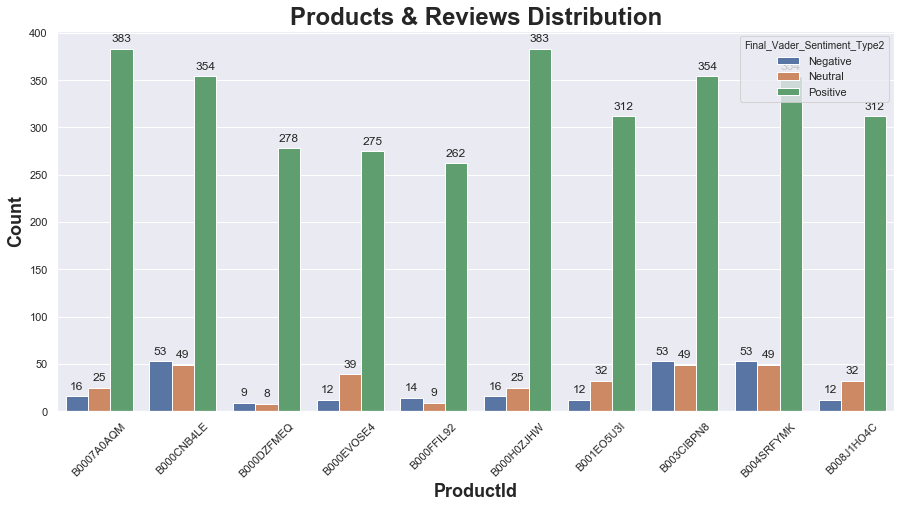

In [88]:
product_review_groupby_vader = df_final.groupby(['ProductId','Final_Vader_Sentiment_Type2']).count()['Id'].reset_index()

plt.figure(figsize=(15, 7))
bar_plot = sns.barplot(x="ProductId", y="Id", hue="Final_Vader_Sentiment_Type2", data=product_review_groupby_vader)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.xticks(rotation=45)
plt.title('Products & Reviews Distribution',fontsize=24, y=1, weight = 'bold')
for p in bar_plot.patches:
    bar_plot.annotate(str(format(p.get_height(), '.0f')), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylabel('Count',fontsize=18, weight = 'bold')
plt.xlabel('ProductId',fontsize=18, weight = 'bold')
plt.show();

# Sentiment Analysis using TF-IDF

In [22]:
df_final = df_final.reset_index()

In [102]:
reviews = []
for i in df_final.index:
    reviews.append(df_final.loc[i,'Text'].lower().split())

In [103]:
# Document Frequency calculation
DF = {}
for i in range(len(reviews)):
    tokens = reviews[i]
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}

In [104]:
## frequency of the word 
for i in DF:
    DF[i]= len(DF[i])
# DF

In [105]:
# calculating TF-IDF
import collections
tf_idf = {}
N = len(reviews) # number of reviews
tf_idf =[] 
for i in range(N):
    tokens = reviews[i]
    counter = collections.Counter(tokens) # contains counts of all words in 1 review
    words_count = len(tokens) # total words in 1 review
    tf_idf_temp ={}
    for token in np.unique(tokens):
        tf = counter[token]/words_count   # count of single word/total words
        df = DF[token]  # document frequency
        
        idf = np.log(N/df)  # IDF
    
        tf_idf_temp[token] =tf*idf #tf-idf
    tf_idf.append(tf_idf_temp)

In [106]:
# Reading the lexicon file and cleaning it to remove '#'
lex = pd.read_excel("General Inquiry lexicon.xls")
lex = lex[1:]
lex['Entry'] = lex['Entry'].astype(str)
special_char_list=['</span','<br/>','<br>','href','</a>''\\','`','\"',"'",'*','_','{','}','[',']','(',')',';','@','^','&','>','#1','+',':','-','_','=','|','>','<','~','.','!','$','/',',','?','%','0','1','2','3','4','5','6','7','8','9']
lex['Entry']=lex['Entry'].apply(clean_text)

In [107]:
pos_word = lex[lex['Positiv'].notnull()]
positive_word =list(pos_word['Entry'])

neg_word = lex[lex['Negativ'].notnull()]
negative_word =list(neg_word['Entry'])

In [108]:
# Considering negations
import nltk
negation=['no', 'not', 'none', 'neither', 'never', 'nobody','nothing','nowhere','hardly','scarcely','barely',"doesnt","isnt","dont","wasnt","shouldnt","wouldnt","couldnt","wont","cant"]
    
def negate_pos(text):
    negative_pos = []
    wordlist=nltk.word_tokenize(text)
    for index,word in enumerate(wordlist):
        if word.upper() in positive_word:
            word1=wordlist[index-1] if index>=1 else 'NA'
            word2=wordlist[index-2] if index>=2 else "NA"
            word3=wordlist[index-3] if index>=3 else "NA"
            if (word1 in negation) or (word2 in negation) or (word3 in negation):
                negative_pos.append(word)
                
    return negative_pos

def negate_neg(text):
    negative_neg = []
    wordlist=nltk.word_tokenize(text)
    for index,word in enumerate(wordlist):
        if word.upper() in negative_word:
            word1=wordlist[index-1] if index>=1 else 'NA'
            word2=wordlist[index-2] if index>=2 else "NA"
            word3=wordlist[index-3] if index>=3 else "NA"
            if (word1 in negation) or (word2 in negation) or (word3 in negation):
                negative_neg.append(word)
    return negative_neg

In [109]:
# Positive Sentiment
pos_sentiment_score=[]
pos_word_number = []
for i in range(len(tf_idf)):
    tf_idf_dict = tf_idf[i]
    pword_counter = 0
    line_sent_score=0
    for word,score in tf_idf_dict.items():
        if word.upper() in positive_word:
            pword_counter =pword_counter+1
            line_sent_score=line_sent_score+score
    # Consider negations
    text = df_final.loc[i,'Text'].lower()
    negated_pos = negate_pos(text)
    negated_neg = negate_neg(text)
    pword_counter = pword_counter - len(negated_pos)
    pword_counter = pword_counter + len(negated_neg)
    
    for pos_word in negated_pos:
        line_sent_score = line_sent_score - tf_idf_dict[pos_word]
    for neg_word in negated_neg:
        line_sent_score = line_sent_score + tf_idf_dict[neg_word]
    
    pos_sentiment_score.append(line_sent_score)
    pos_word_number.append(pword_counter)

In [110]:
# negative sentiment
neg_sentiment_score=[]
neg_word_number=[]
for i in range(len(tf_idf)):
    tf_idf_dict = tf_idf[i]
    nword_counter=0
    line_sent_score=0
    
    for word,score in tf_idf_dict.items():
        if word.upper() in negative_word:
            nword_counter =nword_counter+1
            line_sent_score=line_sent_score+score
    
    # Consider negations
    text = df_final.loc[i,'Text'].lower()       
    negated_pos = negate_pos(text)    
    negated_neg = negate_neg(text)
    nword_counter = nword_counter + len(negated_pos)
    nword_counter = nword_counter - len(negated_neg)
    
    for pos_word in negated_pos:
        line_sent_score = line_sent_score + tf_idf_dict[pos_word]
    for neg_word in negated_neg:
        line_sent_score = line_sent_score - tf_idf_dict[neg_word]
    
    neg_sentiment_score.append(line_sent_score)
    neg_word_number.append(nword_counter)


In [111]:
df_final["neg_sentiment_score"]=neg_sentiment_score

df_final["pos_sentiment_score"]=pos_sentiment_score

df_final["neg_word_count"]=neg_word_number

df_final["pos_word_count"]=pos_word_number

In [112]:
#calculate normalized score
from past.builtins import xrange
nums = [0,len(df_final["Text"])]
normalized_pos_sentiment_score = []
for i in xrange(nums[0],nums[1]):
    word_count=len(df_final.loc[i,"Text"].split(" "))
    normalized_score=(df_final.loc[i,"pos_sentiment_score"])/word_count
    normalized_pos_sentiment_score.append(normalized_score)

In [113]:
# calculate normalized score
from past.builtins import xrange
nums = [0,len(df_final["Text"])]
normalized_neg_sentiment_score = []
for i in xrange(nums[0],nums[1]):
    word_count=len(df_final.loc[i,"Text"].split(" "))
    normalized_score=(df_final.loc[i,"neg_sentiment_score"])/word_count # dividing sentiment score by word count of each review
    normalized_neg_sentiment_score.append(normalized_score)

In [114]:
df_final["normalized_neg__sentiment_score"]=normalized_neg_sentiment_score

df_final["normalized_pos__sentiment_score"]=normalized_pos_sentiment_score

In [115]:
# calculate positive sentiment ratio
positive_ratio = []
for index, row in df_final.iterrows():
    if (row['normalized_pos__sentiment_score'] == 0) and (row['normalized_neg__sentiment_score'] == 0):
        positive_ratio.append(-1)
    else:
        ratio = row['normalized_pos__sentiment_score']/(row['normalized_pos__sentiment_score']+row['normalized_neg__sentiment_score'])
        positive_ratio.append(ratio)
df_final['positive_ratio'] = positive_ratio

In [116]:
# calculated sentiment
df_final.loc[df_final.positive_ratio>0.55,'calculated_sentiment'] = 'Positive'
df_final.loc[(df_final.positive_ratio > 0.45) & (df_final.positive_ratio <= 0.55) ,'calculated_sentiment'] = 'Neutral'
df_final.loc[(df_final.positive_ratio >= 0.000000) & (df_final.positive_ratio <= 0.45) ,'calculated_sentiment'] = 'Negative'
df_final.loc[df_final.positive_ratio == -1 ,'calculated_sentiment'] = 'Undefined'
df_final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,...,Final_Vader_Sentiment_Type2,Final_Vader_Sentiment_Type,neg_sentiment_score,pos_sentiment_score,neg_word_count,pos_word_count,normalized_neg__sentiment_score,normalized_pos__sentiment_score,positive_ratio,calculated_sentiment
0,0,29992,B000DZFMEQ,A3P70L7MF8L3L3,J. E. Pote,1,1,5,1268179200,Pamela's Bread Mix,...,Positive,neu,0.032480,0.183971,1,8,0.000244,0.001383,0.849943,Positive
1,1,29993,B000DZFMEQ,A1ASH1LE6HZ3Y3,Linda M. Walker,1,1,2,1256947200,Dated,...,Positive,neu,0.054801,0.071998,2,2,0.000412,0.000541,0.567814,Positive
2,2,29994,B000DZFMEQ,A32PVZEV0QTHMK,Manisha,1,1,3,1256515200,TOO SWEET,...,Positive,neu,0.233839,0.000000,1,0,0.004412,0.000000,0.000000,Negative
3,3,29995,B000DZFMEQ,A1RRCP78CDDIOS,"Beth Wisser ""Beth""",1,1,3,1254268800,Not the best,...,Positive,neu,0.051380,0.000000,1,0,0.000901,0.000000,0.000000,Negative
4,4,29996,B000DZFMEQ,AU714FVNMGW4E,"Anita L. Burnham ""Anita B""",1,1,5,1253750400,Gluten Free Goodness,...,Positive,neu,0.000000,0.174825,0,5,0.000000,0.003122,1.000000,Positive


# Sentiment analysis with Textblob

In [117]:
df_textBlob = copy.deepcopy(df_final)

In [118]:
df_textBlob.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,...,Final_Vader_Sentiment_Type2,Final_Vader_Sentiment_Type,neg_sentiment_score,pos_sentiment_score,neg_word_count,pos_word_count,normalized_neg__sentiment_score,normalized_pos__sentiment_score,positive_ratio,calculated_sentiment
0,0,29992,B000DZFMEQ,A3P70L7MF8L3L3,J. E. Pote,1,1,5,1268179200,Pamela's Bread Mix,...,Positive,neu,0.032480,0.183971,1,8,0.000244,0.001383,0.849943,Positive
1,1,29993,B000DZFMEQ,A1ASH1LE6HZ3Y3,Linda M. Walker,1,1,2,1256947200,Dated,...,Positive,neu,0.054801,0.071998,2,2,0.000412,0.000541,0.567814,Positive
2,2,29994,B000DZFMEQ,A32PVZEV0QTHMK,Manisha,1,1,3,1256515200,TOO SWEET,...,Positive,neu,0.233839,0.000000,1,0,0.004412,0.000000,0.000000,Negative
3,3,29995,B000DZFMEQ,A1RRCP78CDDIOS,"Beth Wisser ""Beth""",1,1,3,1254268800,Not the best,...,Positive,neu,0.051380,0.000000,1,0,0.000901,0.000000,0.000000,Negative
4,4,29996,B000DZFMEQ,AU714FVNMGW4E,"Anita L. Burnham ""Anita B""",1,1,5,1253750400,Gluten Free Goodness,...,Positive,neu,0.000000,0.174825,0,5,0.000000,0.003122,1.000000,Positive


In [119]:
for i in df_textBlob.index:
    text = TextBlob(df_textBlob.loc[i,'Text'])
    df_textBlob.loc[i,'polarity'] = text.sentiment.polarity
    df_textBlob.loc[i,'subjectivity'] = text.sentiment.subjectivity
    
    if text.sentiment.polarity >0 and text.sentiment.subjectivity > 0.5:
        df_textBlob.loc[i,'TextBlob_Sentiment'] = 'Positive'
    elif text.sentiment.polarity <= 0 and text.sentiment.subjectivity > 0.5:
        df_textBlob.loc[i,'TextBlob_Sentiment'] = 'Negative'
    else:
        df_textBlob.loc[i,'TextBlob_Sentiment'] = 'Neutral'


In [120]:
df_textBlob.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,...,pos_sentiment_score,neg_word_count,pos_word_count,normalized_neg__sentiment_score,normalized_pos__sentiment_score,positive_ratio,calculated_sentiment,polarity,subjectivity,TextBlob_Sentiment
0,0,29992,B000DZFMEQ,A3P70L7MF8L3L3,J. E. Pote,1,1,5,1268179200,Pamela's Bread Mix,...,0.183971,1,8,0.000244,0.001383,0.849943,Positive,0.416807,0.598179,Positive
1,1,29993,B000DZFMEQ,A1ASH1LE6HZ3Y3,Linda M. Walker,1,1,2,1256947200,Dated,...,0.071998,2,2,0.000412,0.000541,0.567814,Positive,-0.010606,0.537121,Negative
2,2,29994,B000DZFMEQ,A32PVZEV0QTHMK,Manisha,1,1,3,1256515200,TOO SWEET,...,0.000000,1,0,0.004412,0.000000,0.000000,Negative,0.234375,0.587500,Positive
3,3,29995,B000DZFMEQ,A1RRCP78CDDIOS,"Beth Wisser ""Beth""",1,1,3,1254268800,Not the best,...,0.000000,1,0,0.000901,0.000000,0.000000,Negative,0.034722,0.490278,Neutral
4,4,29996,B000DZFMEQ,AU714FVNMGW4E,"Anita L. Burnham ""Anita B""",1,1,5,1253750400,Gluten Free Goodness,...,0.174825,0,5,0.000000,0.003122,1.000000,Positive,0.637500,0.768750,Positive


# Check the accuracy

In [121]:
def accuracy(df):
    acc1 = len(np.where(df['TextBlob_Sentiment']==df['Score_Sentiment'])[0])/len(df)*100
    acc2 = len(np.where(df['calculated_sentiment']==df['Score_Sentiment'])[0])/len(df)*100
    acc3 = len(np.where(df['Final_Vader_Sentiment_Type2']==df['Score_Sentiment'])[0])/len(df)*100
    data = [['TextBlob',acc1],['TF-IDF',acc2],['Vader',acc3]]
    df = pd.DataFrame(data,columns=['Methods','Accuracy'])
    return df

In [122]:
accuracy(df_textBlob)

,Methods,Accuracy
0,TextBlob,57.694314
1,TF-IDF,67.501304
2,Vader,79.968701


### Word Cloud

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
stop_words=stopwords.words("english")

In [17]:
lex = pd.read_excel("General Inquiry lexicon.xls")
lex = lex[1:]
lex['Entry'] = lex['Entry'].astype(str)
special_char_list=['</span','<br/>','<br>','href','</a>''\\','`','\"',"'",'*','_','{','}','[',']','(',')',';','@','^','&','>','#1','+',':','-','_','=','|','>','<','~','.','!','$','/',',','?','%','0','1','2','3','4','5','6','7','8','9']
lex['Entry']=lex['Entry'].apply(clean_text)

neg_word = lex[lex['Negativ'].notnull()]
negative_word =list(neg_word['Entry'])

pos_word = lex[lex['Positiv'].notnull()]
positive_word =list(pos_word['Entry'])

### Wordcloud to show comparison of postivie/negative phrases as the number of reviews changes over years

In [23]:
from collections import Counter
def word_cloud(Product, Year, Sentiment, Wordlist):
    df_word_cloud = df_final[(df_final['ProductId'] == Product) & (df_final['Final_Vader_Sentiment_Type2'] == Sentiment) & (df_final['Year']== Year)]
    Reviews = list(df_word_cloud['Text'])
    w_cloud = {}
    for review in Reviews:
        stop_words=stopwords.words("english")
        wordlist=nltk.word_tokenize(review) 
        filtered=[w for w in wordlist if w.lower() not in stop_words] 
        for j, word in enumerate(filtered):
            if word.upper() in Wordlist and j < len(filtered) - 1:
                phrase = filtered[j] + " " + filtered[j+1]
                if phrase.lower() not in w_cloud:
                    w_cloud[phrase.lower()] = 1
                else:
                    w_cloud[phrase.lower()] += 1
    dict_sort =dict(Counter(w_cloud).most_common())
    wc = WordCloud(background_color="white", max_font_size=150, max_words=150, width = 800, height = 800).generate_from_frequencies(dict_sort)
    return wc

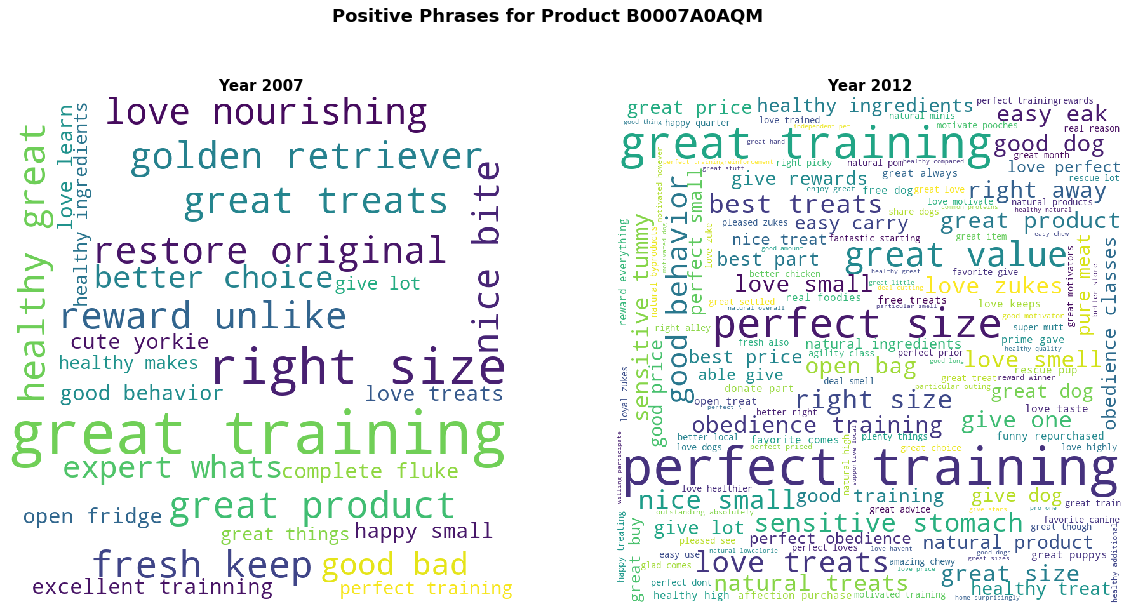

In [24]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,2,1)
wordcloud = word_cloud('B0007A0AQM', 2007, 'Positive', positive_word)
ax2 = fig.add_subplot(1,2,2)
wordcloud2 = word_cloud('B0007A0AQM', 2012, 'Positive', positive_word)
ax.imshow(wordcloud)
ax2.imshow(wordcloud2)
ax.axis('off')
ax2.axis('off')
fig.suptitle("Positive Phrases for Product B0007A0AQM", fontsize = 18 , fontweight = 'bold')
ax.set_title("Year 2007", fontsize = 15,fontweight = 'bold')
ax2.set_title("Year 2012",fontsize = 15,fontweight = 'bold')
plt.show()

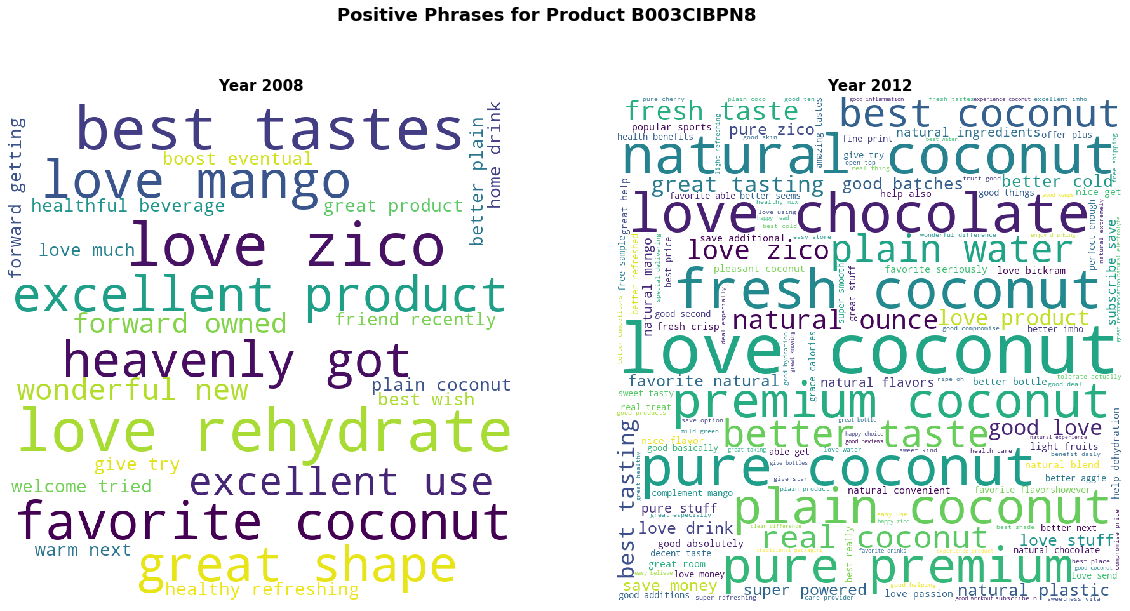

In [25]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,2,1)
wordcloud = word_cloud('B003CIBPN8', 2008, 'Positive', positive_word)
ax2 = fig.add_subplot(1,2,2)
wordcloud2 = word_cloud('B003CIBPN8', 2012, 'Positive', positive_word)
ax.imshow(wordcloud)
ax2.imshow(wordcloud2)
ax.axis('off')
ax2.axis('off')
fig.suptitle("Positive Phrases for Product B003CIBPN8", fontsize = 18 , fontweight = 'bold')
ax.set_title("Year 2008", fontsize = 15,fontweight = 'bold')
ax2.set_title("Year 2012",fontsize = 15,fontweight = 'bold')
plt.show()

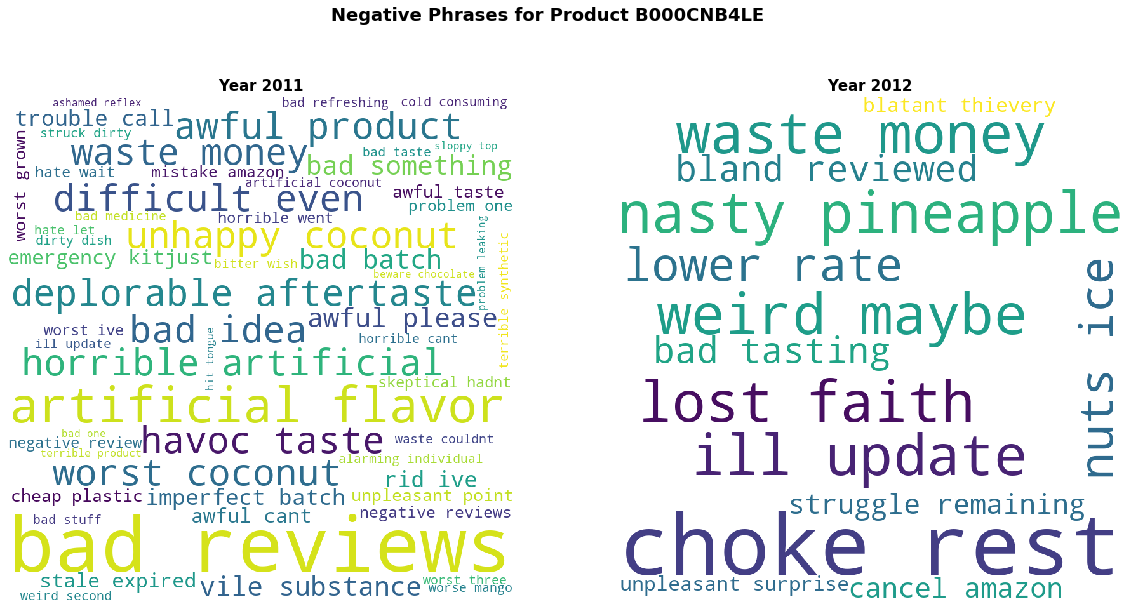

In [26]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,2,1)
wordcloud = word_cloud('B000CNB4LE', 2011, 'Negative', negative_word)
ax2 = fig.add_subplot(1,2,2)
wordcloud2 = word_cloud('B000CNB4LE', 2012, 'Negative', negative_word)
ax.imshow(wordcloud)
ax2.imshow(wordcloud2)
ax.axis('off')
ax2.axis('off')
fig.suptitle("Negative Phrases for Product B000CNB4LE", fontsize = 18 , fontweight = 'bold')
ax.set_title("Year 2011", fontsize = 15,fontweight = 'bold')
ax2.set_title("Year 2012",fontsize = 15,fontweight = 'bold')
plt.show()